# Analysis from Brian Goggin (uses newly-produced data as of September 2017)

In [311]:
import pandas as pd
import logging
import dateutil
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
%matplotlib inline
pd.set_option('display.max_columns', 500)

In [312]:
#import dataset of project times from "data" folder
file = "../../../data/cleaned/all_quarters__one_record_per_project.csv"
output="../../Output/"
df = pd.read_csv(file)

# Initial Data Cleaning

In [313]:
#First, filter out those projects that are exclusively non-residential (defined as those without units)
df = df[df['units'] > 0]

In [314]:
#Next, keep only those that reached completion at some point over the time period
#by leaving out this, we actually have less of a sample size for some of the charts 
#because there is more chance for duplicate building permits
#df=df[pd.notnull(df['comp_date'])]

In [315]:
df.shape

(2966, 26)

In [316]:
df=df[pd.notnull(df['firstfiled'])]
df=df[df['firstfiled'] !='']

In [317]:
df.shape

(2791, 26)

In [318]:
#drop duplicates for now, until manual cleaning is done
df= df[~ df.duplicated('dbi_permit', keep=False)]

In [319]:
df.shape

(2248, 26)

In [320]:
df['project_time_years']=df['project_duration_days']/365

In [321]:
# Top 5 longest projects
df.sort_values('project_time_years', ascending = False)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,project_time_years
189,18560,NaN,833-881 JAMESTOWN,4991277,2007-09-17,CONSTRUCTION,04/01/2015,2007-09-17,9924080S,1991-02-19,2007-09-17,1991-02-19,2007-09-17,CONSTRUCTION,"('2007-09-17', '2007-09-17', '2007-09-17', '20...",8807.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",1,2015,Under Construction,132.0,14.0,-122.392222,37.717174,RH-2,RH-2,24.128767
495,17247,2008-11-07,1179 TENNESSEE ST,4172053,2014-12-18,CONSTRUCTION,01/01/2015,2014-03-21,9902819.0,1999-02-11,2008-11-07,1999-02-11,2014-12-18,CONSTRUCTION,"('2008-11-07', '2009-11-03', '2009-11-03', '20...",5803.0,"('BP REINSTATED', 'BP REINSTATED', 'BP REINSTA...",4,2014,Under Construction,8.0,8.0,-122.389058,37.755993,UMU,UMU,15.898630
1289,24780,2014-02-12,480 POTRERO AV,3973002C,2016-01-13,CONSTRUCTION,07/01/2016,2015-03-26,201306250465,2002-03-22,2004-08-17,2002-03-22,2016-01-13,CONSTRUCTION,"('2004-08-17', '2012-10-04', '2012-10-04', '20...",5215.0,"('BP ISSUED', 'PL FILED', 'PL FILED', 'BP FILE...",2,2016,Under Construction,77.0,77.0,-122.407671,37.763478,UMU,UMU,14.287671
2270,27882,2013-10-31,TRINITY PLAZA PHASE III,3702391,2016-11-09,CONSTRUCTION,01/01/2017,2015-10-14,201209069080,2002-11-21,2013-10-31,2002-11-21,2016-11-09,CONSTRUCTION,"('2013-10-31', '2015-10-14', '2015-12-21', '20...",5155.0,"('BP ISSUED', 'CONSTRUCTION', 'CONSTRUCTION', ...",4,2016,Under Construction,550.0,550.0,-122.413013,37.777926,C-3-G,C-3-G,14.123288
2739,21674,NaN,950 CORBETT AV,2799013,2007-03-13,CONSTRUCTION,01/01/2016,2007-03-13,200201106632.0,2002-01-10,2007-03-13,2002-01-10,2007-03-13,CONSTRUCTION,"('2007-03-13', '2007-03-13', '2007-03-13', '20...",5104.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",4,2015,Under Construction,3.0,3.0,-122.443730,37.751832,RM-1,RM-1,13.983562


In [322]:
# Top 5 shortest projects
df.sort_values('project_time_years', ascending = True)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,project_time_years
1594,2346,NaN,850 30TH AV,1672024,2010-02-24,CONSTRUCTION,04/01/2010,2010-02-24,200910269851,2009-10-26,2009-10-26,2009-10-26,2010-02-24,CONSTRUCTION,"('2009-10-26', '2010-02-24')",157.0,"('BP FILED', 'CONSTRUCTION')",1,2010,Under Construction,2.0,NaN,-122.489282,37.773244,RH-2,RH-2,0.430137
3156,21046,NaN,414 SOMERSET ST,6044003,2015-10-05,CONSTRUCTION,2015-10-05,2015-10-05,201504103396.0,2015-04-10,2015-04-10,2015-04-10,2015-10-05,CONSTRUCTION,"('2015-04-10', '2015-10-05')",178.0,"('BP FILED', 'CONSTRUCTION')",3,2015,Under Construction,2.0,1.0,-122.407649,37.726252,RH-1,RH-1,0.487671
1023,10900,2012-10-23,28 PRECITA AV,5518023,2012-11-15,CONSTRUCTION,01/01/2013,2012-11-15,201206203050,2012-06-20,2012-06-20,2012-06-20 00:00:00,2012-11-15,CONSTRUCTION,"('2012-06-20', '2012-10-23', '2012-11-15')",195.0,"('BP FILED', 'BP ISSUED', 'CONSTRUCTION')",4,2012,Under Construction,2.0,1.0,-122.418489,37.746472,RH-2,RH-2,0.534247
982,10897,2012-10-26,55 05TH ST,3705039,2012-12-12,CONSTRUCTION,01/01/2013,2012-12-12,201206202986,2012-06-20,2012-06-20,2012-06-20 00:00:00,2012-12-12,CONSTRUCTION,"('2012-06-20', '2012-10-26', '2012-12-12')",195.0,"('BP FILED', 'BP APPROVED', 'CONSTRUCTION')",4,2012,Under Construction,116.0,8.0,-122.407185,37.783461,C-3-R,C-3-R,0.534247
2718,656,NaN,64 14TH ST,3529017,2009-08-07,CONSTRUCTION,10/01/2009,2009-08-07,200903194471,2009-03-19,2009-08-07,2009-03-19,2009-08-07,CONSTRUCTION,"('2009-08-07',)",196.0,"('CONSTRUCTION',)",3,2009,Under Construction,1.0,-1.0,-122.414942,37.768706,PDR-1-G,PDR-1-G,0.536986


In [323]:
#Manual Data Cleaning for some fishy values based on top 5 shortest list above
#df.loc[(df['address']=='55 05TH ST') & (new_df['apn']=='3705039'), 'units'] = 8 #looked up on PIM. Simple adding 8 units.
#df.loc[(df['address']=='545 POST ST') & (new_df['apn']=='0306022'), 'units'] = 4 #looked up on PIM. Simple adding 4 units
#df.loc[(df['address']=='555 POST ST') & (new_df['apn']=='0306020'), 'units'] = 17 #looked up on PIM. Simple adding 4 units
#df.loc[(df['address']=='515 JOHN MUIR DR') & (new_df['apn']=='7282005'), 'units'] = 2 #looked up on PIM. Change of use to residential. 2 additional units

#based on the above cases, unit count seems to be the unit count at the site at the end of 
#the project rather than the unit count of the project itself. Because of this, I will be adjust
#unit counts that are more than the net units added to the net units added amount. If units net
#is missing, just accept unit count as true for now.

def unit_change(value):
    return_val=value['units']
    if pd.notnull(value['unitsnet']):
        if value['unitsnet']<0:
            return_val = value['units']
        elif value['unitsnet']==0:
            return_val = value['units']
        elif value['unitsnet']<value['units']:
            return_val = value['unitsnet']
        else:
            return_val=value['units']
    return return_val

df['units']=df.apply(unit_change, axis=1)
 

In [324]:
df['project_time_years'].describe()

count    704.000000
mean       4.504238
std        3.047139
min        0.430137
25%        2.105479
50%        3.806849
75%        6.327397
max       24.128767
Name: project_time_years, dtype: float64

# Merge in Geographic Information and Make Big Dataframe

In [325]:
#first, convert points to geodataframe
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(df.x, df.y)]
devs = GeoDataFrame(df, crs=crs, geometry=geometry)
devs = devs.to_crs({'init': 'epsg:4326'}) 

In [326]:
#import neighborhoods
neighborhoods = gpd.read_file('../../../data/gis/41_neighborhoods/41_neighborhoods.shp')

In [327]:
#convert boundaries to geographic coordinate system to conform to points
neighborhoods = neighborhoods.to_crs({'init': 'epsg:4326'}) 

In [328]:
#First, spatial join between points and neighborhood boundaries. Set 'how' to 'left' to preserve all developments
df = gpd.sjoin(devs, neighborhoods, how = 'inner', op='within')
df.shape

(2248, 30)

In [329]:
#Create Big Projects Dataframe
df_big=df[df['units']>=10]
df_big['project_time_years'].describe()

count    143.000000
mean       6.040406
std        3.420167
min        0.750685
25%        3.489041
50%        5.558904
75%        8.030137
max       24.128767
Name: project_time_years, dtype: float64

In [330]:
# Top 5 shortest projects of big projects
df_big.sort_values('project_time_years', ascending = True)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,project_time_years,geometry,index_right,nhood
2864,22619,NaN,1155 MARKET ST,3702054,2016-02-23,CONSTRUCTION,04/01/2016,2016-02-23,201507020526.0,2015-07-02,2016-02-23,2015-07-02,2016-02-23,CONSTRUCTION,"('2016-02-23',)",274.0,"('CONSTRUCTION',)",1,2016,Under Construction,11.0,11.0,-122.413409,37.779223,C-3-G,C-3-G,0.750685,POINT (-122.413409 37.7792227726),33,South of Market
1042,23515,2015-07-24,555 POST ST,0306020,2016-02-29,CONSTRUCTION,04/01/2016,2016-02-29,201504224344.0,2015-04-22,2015-07-24,2015-04-22,2016-02-29,CONSTRUCTION,"('2015-07-24', '2015-07-24', '2016-01-04', '20...",345.0,"('BP ISSUED', 'BP ISSUED', 'BP ISSUED', 'CONST...",1,2016,Under Construction,17.0,17.0,-122.410943,37.787683,C-3-G,C-3-G,0.945205,POINT (-122.410943 37.787682827),35,Tenderloin
155,15815,2013-07-23,1816 EDDY ST,1127064,2014-02-07,CONSTRUCTION,07/01/2014,2014-02-07,201304265571,2013-04-26,2013-07-23,2013-04-26,2014-02-07,CONSTRUCTION,"('2013-07-23', '2013-07-23', '2014-02-07', '20...",431.0,"('BP ISSUED', 'BP ISSUED', 'CONSTRUCTION', 'CO...",2,2014,Under Construction,19.0,19.0,-122.437260,37.780796,RM-3,RM-3,1.180822,POINT (-122.43726 37.780796),40,Western Addition
681,8543,2011-08-16,350 GOLDEN GATE AV,0346005,2012-02-13,CONSTRUCTION,04/01/2012,2012-01-13,201011014101,2010-11-01,2010-11-01,2010-11-01,2012-02-13,CONSTRUCTION,"('2010-11-01', '2010-11-01', '2010-11-01', '20...",517.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP ISSUE...",1,2012,Under Construction,19.0,19.0,-122.416512,37.781546,C-3-G,C-3-G,1.416438,POINT (-122.4165125 37.781546),35,Tenderloin
827,26629,2016-01-22,1300 04TH ST,8711021,2016-10-25,CONSTRUCTION,01/01/2017,2016-10-25,201507272485,2015-07-27,2015-07-27,2015-07-27,2016-10-25,CONSTRUCTION,"('2015-07-27', '2015-07-27', '2016-01-22', '20...",524.0,"('BP FILED', 'BP FILED', 'BP ISSUED', 'BP ISSU...",4,2016,Under Construction,143.0,143.0,-122.391772,37.771402,MB-RA,MB-RA,1.435616,POINT (-122.391771649 37.77140196040001),19,Mission Bay


# Zoning Exploration

In [331]:
df['zoning_simplified'].value_counts()

conv_res = ['RH-1(D)', 'RH-1', 'RH-1(S)', 'RH-2', 'RH-3']
apt_res=['RM-1', 'RM-2', 'RM-3', 'RM-4']
mixed_res=['RC-3', 'RC-4', 'RED', 'RTO', 'RC-4']
nhb_comm=['NC-1', 'NC-2', 'NC-3', 'NC-S', 'NCD', 'NCT'] #NCD and NCT encompass all types of NCD, NCTs
comm=['C-2', 'C-3', 'C-M']
indus=['M-1', 'M-2']
other=[]

def zoning_simple(value):
    zone_class='Other'
    for item in conv_res:
        if value['zoning'].find(item)>=0:
            zone_class= 'Conventional Residential'
    for item in apt_res:
        if value['zoning'].find(item)>=0: 
            zone_class= 'Apartment Residential'
    for item in mixed_res:
        if value['zoning'].find(item)>=0: 
            zone_class= 'Mixed Residential'
    for item in nhb_comm:
        if value['zoning'].find(item)>=0: 
            zone_class= 'Nhb Commercial'
    for item in comm:
        if value['zoning'].find(item)>=0: 
            zone_class= 'Standard Commercial'
    for item in indus:
        if value['zoning'].find(item)>=0: 
            zone_class= 'Industrial'
    return zone_class

df['zone_class']=df.apply(zoning_simple, axis=1)


In [332]:
df['zone_class'].value_counts()

Conventional Residential    1286
Other                        233
Nhb Commercial               216
Standard Commercial          182
Industrial                   172
Mixed Residential            138
Apartment Residential         21
Name: zone_class, dtype: int64

In [333]:
def bar_graph(var_x,var_y, title, x_label, y_label, df=df, sortedvar=False, graph_options=['red', (8, 6)]):
    """
    Function to make bar graphs by subgroup for median time to completion.
    """
    medians=[]
    sample_size=0
    value_names=df[var_x].value_counts(sort=False).index
    if sortedvar==True:
        value_names=sorted(value_names, key=lambda x: df[df[var_x]==x][var_y].median())
    for i in value_names:
        median = df[df[var_x]==i][var_y].median()
        sample_size=sample_size+df[df[var_x]==i][var_y].count() #count sample size for non-missing y variable
        medians.append(median)
        
    y_pos = np.arange(len(df[var_x].value_counts(sort=False).index))
    categories=[]
    for cat in value_names:
        categories.append(cat)
        
    fig, ax = plt.subplots(figsize=graph_options[1])
    plt.title(title+ ' n='+ str(sample_size), fontsize=20)
    ax.bar(y_pos, medians, align='center', alpha=0.5, color = graph_options[0])
    ax.set_xticks(y_pos)
    ax.set_xticklabels(categories, rotation=45)
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    for tick in ax.xaxis.get_majorticklabels():
        tick.set_horizontalalignment("right")
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()


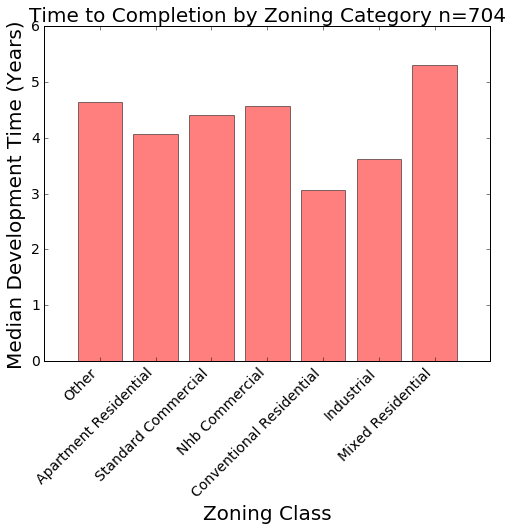

In [334]:
bar_graph('zone_class','project_time_years', 'Time to Completion by Zoning Category','Zoning Class', 'Median Development Time (Years)')

# Project Times by Years

In [335]:
df['year_start']=df['first_date'].str[0:4].astype(int)

In [336]:
year_medians=[]
for i in df['year_start'].value_counts(sort=False).index:
    median = df[df['year_start']==i]['project_time_years'].median()
    year_medians.append(median)

In [337]:
y_pos = np.arange(len(df['year_start'].value_counts(sort=False).index))

In [338]:
categories=[]
for cat in df['year_start'].value_counts(sort=False).index:
    categories.append(cat)

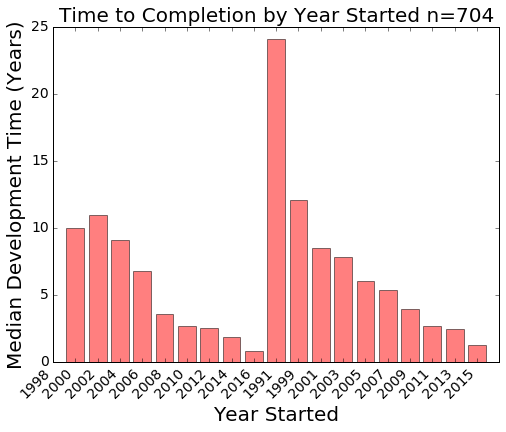

In [339]:
bar_graph('year_start','project_time_years', 'Time to Completion by Year Started','Year Started', 'Median Development Time (Years)')

# Figure 1. Histograms

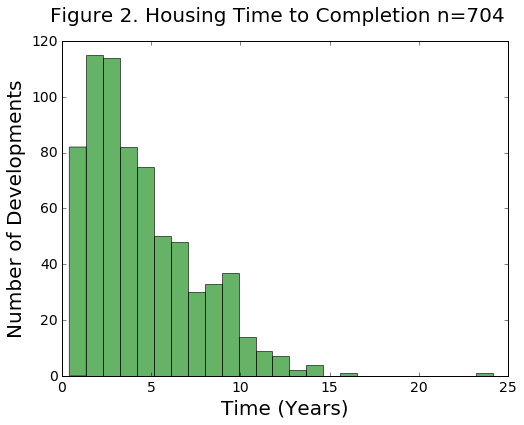

In [340]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 2. Housing Time to Completion' + ' n='+str(df[pd.notnull(df['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.xlabel('Time (Years)', fontsize = 20)
plt.ylabel('Number of Developments', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df[pd.notnull(df['project_time_years'])]['project_time_years'], bins=25, alpha=.6, color='g')
plt.savefig(output+'hitogram.png')
plt.show()

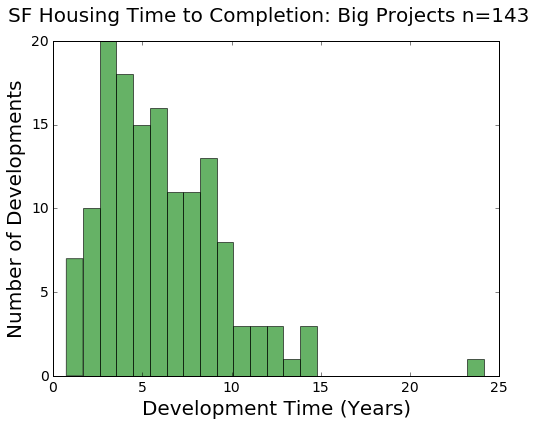

In [341]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('SF Housing Time to Completion: Big Projects'+ ' n='+str(df_big[pd.notnull(df_big['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.xlabel('Development Time (Years)', fontsize = 20)
plt.ylabel('Number of Developments', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df_big[pd.notnull(df_big['project_time_years'])]['project_time_years'], bins=25, alpha=.6, color='g')
plt.show()

# Figure 2. Years Per Unit Histogram

In [342]:
# Project review time, normalized by amount of units
#create unit-year category so that we normalize by units when comparing geographies
df['years_per_unit']=df['project_time_years']/df['units']

In [343]:
df['years_per_unit'].describe()

count    704.000000
mean       2.581069
std        2.549590
min        0.004154
25%        0.679863
50%        1.890411
75%        3.648630
max       13.243836
Name: years_per_unit, dtype: float64

In [344]:
df.sort_values('years_per_unit', ascending = False)[0:5]

,Unnamed: 0,BP_date,address,apn,best_date,best_stat,comp_date,con_date,dbi_permit,first_date,first_project_record_date,firstfiled,latest_project_record_date,latest_project_status,project_dates,project_duration_days,project_statuses,report_quarter,report_year,status,units,unitsnet,x,y,zoning,zoning_simplified,project_time_years,geometry,index_right,nhood,zone_class,year_start,years_per_unit
1771,12833,NaN,1245 DOLORES ST,6534024,2006-11-30,CONSTRUCTION,10/01/2013,2006-11-30,200007074553,2000-07-07,2006-11-30,2000-07-07,2006-11-30,CONSTRUCTION,"('2006-11-30', '2006-11-30', '2006-11-30', '20...",4834.0,"('CONSTRUCTION', 'CONSTRUCTION', 'CONSTRUCTION...",3,2013,Under Construction,1.0,1.0,-122.424732,37.749343,RH-3,RH-3,13.243836,POINT (-122.424732 37.749343),18,Mission,Conventional Residential,2000,13.243836
2622,21967,2009-08-07,652 LAKEVIEW AV,7016023,2013-06-24,CONSTRUCTION,01/01/2016,2013-06-24,200311240936.0,2003-11-24,2009-08-07,2003-11-24,2013-06-24,CONSTRUCTION,"('2009-08-07', '2009-08-07', '2009-08-07', '20...",4421.0,"('BP APPROVED', 'BP APPROVED', 'BP APPROVED', ...",4,2015,Under Construction,1.0,1.0,-122.457741,37.718436,RH-1,RH-1,12.112329,POINT (-122.457740668 37.7184362783),23,Oceanview/Merced/Ingleside,Conventional Residential,2003,12.112329
3212,21973,2010-04-13,23 SPARTA ST,6176011,2015-12-10,CONSTRUCTION,01/01/2016,2015-05-18,200401063464.0,2004-01-06,2004-01-06,2004-01-06,2015-12-10,CONSTRUCTION,"('2004-01-06', '2010-04-13', '2010-06-04', '20...",4378.0,"('BP FILED', 'BP APPROVED', 'BP ISSUED', 'BP I...",4,2015,Under Construction,1.0,1.0,-122.403330,37.717794,RH-1,RH-1,11.994521,POINT (-122.403329904 37.7177938414),38,Visitacion Valley,Conventional Residential,2004,11.994521
699,21835,2009-02-09,1310 STANYAN ST,2706035,2012-07-05,CONSTRUCTION,01/01/2016,2010-12-07,200407158977.0,2004-07-15,2009-02-09,2004-07-15,2012-07-05,CONSTRUCTION,"('2009-02-09', '2009-02-09', '2009-02-09', '20...",4187.0,"('BP APPROVED', 'BP APPROVED', 'BP APPROVED', ...",4,2015,Under Construction,1.0,1.0,-122.451007,37.758409,RH-1(D),RH-1(D),11.471233,POINT (-122.451006674 37.758409222),37,Twin Peaks,Conventional Residential,2004,11.471233
3122,27389,2015-01-26,4126 17TH ST,2623028,2016-07-29,CONSTRUCTION,01/01/2017,2016-07-29,201405307098,2005-12-08,2005-12-08,2005-12-08,2016-07-29,CONSTRUCTION,"('2005-12-08', '2005-12-08', '2005-12-08', '20...",4042.0,"('BP FILED', 'BP FILED', 'BP FILED', 'BP FILED...",4,2016,Under Construction,1.0,1.0,-122.437954,37.762612,RH-3,RH-3,11.073973,POINT (-122.437954318 37.7626118963),2,Castro/Upper Market,Conventional Residential,2005,11.073973


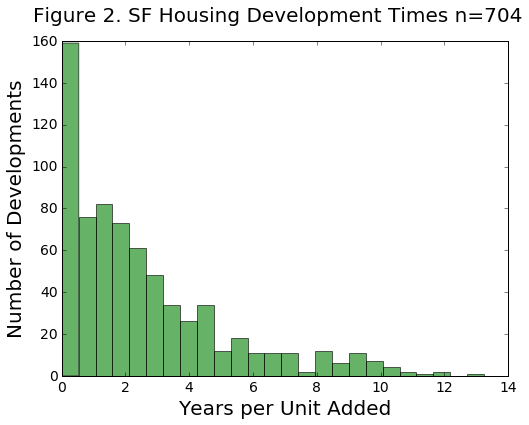

In [345]:
plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 2. SF Housing Development Times' + ' n='+str(df[pd.notnull(df['years_per_unit'])].count()['years_per_unit']), fontsize=20)
plt.xlabel('Years per Unit Added', fontsize=20)
plt.ylabel('Number of Developments', fontsize=20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
ax = plt.hist(df[pd.notnull(df['years_per_unit'])]['years_per_unit'], bins=25, alpha=.6, color='g')
plt.savefig(output+'hitogram_yearunits.png')
plt.show()

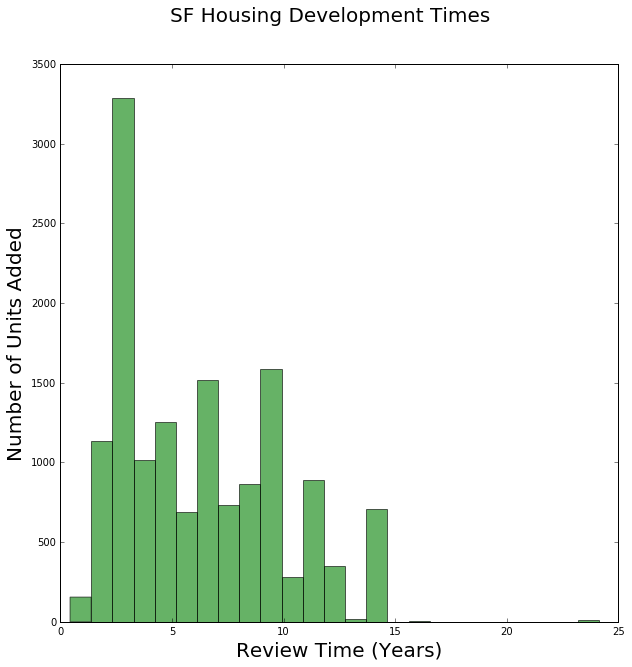

In [346]:
#Create dataset units added by years for each unit
list = []
uniqueid = 0
for index, row in df.iterrows():
    amount = int(row['units'])
    for units in range(0, amount):
        dictionary = {}
        dictionary['id']=uniqueid+1
        dictionary['time']=row['project_time_years']
        list.append(dictionary)
        uniqueid=uniqueid+1
df_units = pd.DataFrame(list)

plt.figure(1, figsize=(10,10), )
plt.suptitle('SF Housing Development Times', fontsize=20)
plt.xlabel('Review Time (Years)', fontsize = 20)
plt.ylabel('Number of Units Added', fontsize = 20)
ax = plt.hist(df_units[pd.notnull(df_units['time'])]['time'], bins=25, alpha=.6, color='g')
plt.savefig(output+'hitogram_units.png')
plt.show()

In [347]:
df_units['time'].describe()

count    14493.000000
mean         6.241513
std          3.655959
min          0.430137
25%          2.852055
50%          5.728767
75%          9.326027
max         24.128767
Name: time, dtype: float64

# Figure 4. Scatter Plots

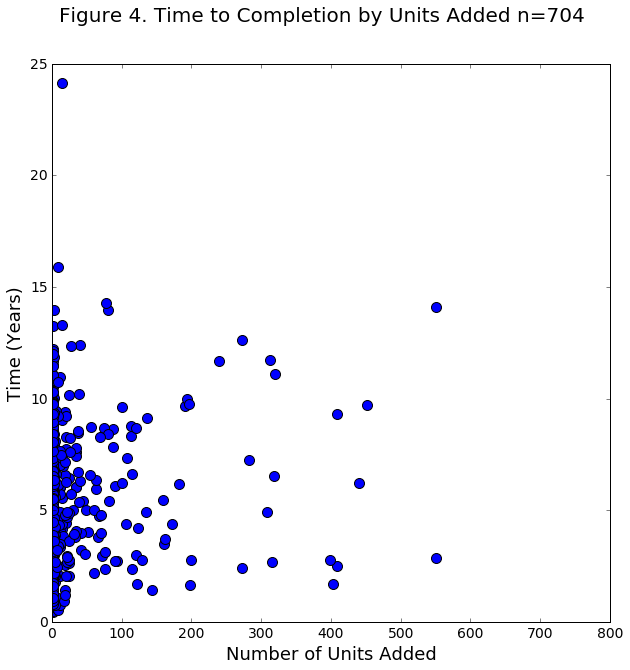

In [348]:
plt.figure(1, figsize=(10,10))
plt.scatter(df['units'], df['project_time_years'], s=100)
plt.suptitle('Figure 4. Time to Completion by Units Added' + ' n='+str(df[pd.notnull(df['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.ylabel('Time (Years)', fontsize = 18)
plt.xlabel('Number of Units Added', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.xlim([0,800])
plt.ylim([0,25])
plt.savefig(output+'scatter.png')

(0, 25)

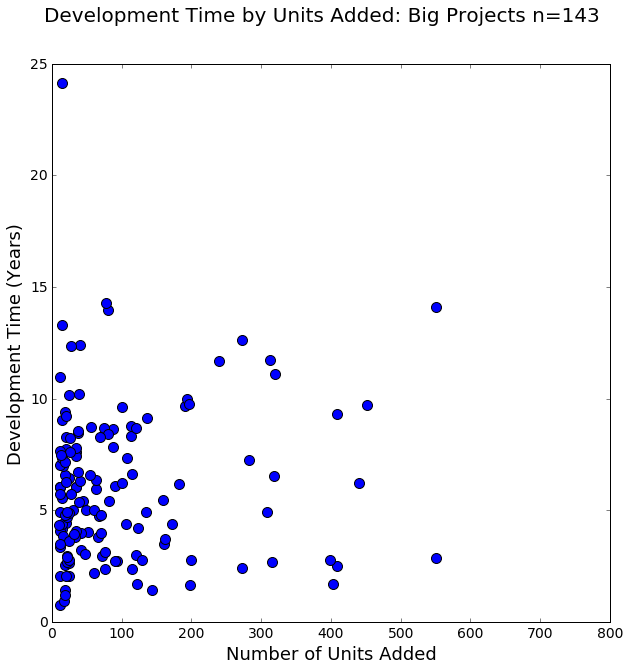

In [349]:
plt.figure(1, figsize=(10,10))
plt.scatter(df_big['units'], df_big['project_time_years'], s=100)
plt.suptitle('Development Time by Units Added: Big Projects' + ' n='+str(df_big[pd.notnull(df_big['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.ylabel('Development Time (Years)', fontsize = 18)
plt.xlabel('Number of Units Added', fontsize = 18)
plt.xticks(fontsize=14)
plt.yticks(fontsize = 14)
plt.xlim([0,800])
plt.ylim([0,25])

# Figure 5. Plot by unit category

In [350]:
unit_cutoffs=[10, 50, 100, 200]
def unit_categories(value):
    if value['units'] <unit_cutoffs[0]:
        field = '0'+'-'+str(unit_cutoffs[0])
    elif (value['units'] >=unit_cutoffs[0]) & (value['units'] <unit_cutoffs[1]):
        field = str(unit_cutoffs[0])+'-'+str(unit_cutoffs[1])
    elif (value['units']>= unit_cutoffs[1]) & (value['units'] <unit_cutoffs[2]):
        field = str(unit_cutoffs[1])+'-'+str(unit_cutoffs[2])
    elif (value['units']>= unit_cutoffs[2]) & (value['units'] <200):
        field = str(unit_cutoffs[2])+'-'+str(unit_cutoffs[3])
    elif value['units']>=200:
        field = '>'+str(unit_cutoffs[3])
    return field
    
df['unitcat']=df.apply(unit_categories, axis=1)
df_big['unitcat']=df_big.apply(unit_categories, axis=1)

/Users/briangoggin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [351]:
df['unitcat'].value_counts()

0-10       1847
10-50       186
50-100       87
100-200      75
>200         53
Name: unitcat, dtype: int64

In [352]:
#bar_graph('unitcat','project_time_years', 'Time to Completion by Size Category','Size (Units)', 'Time (Years)')

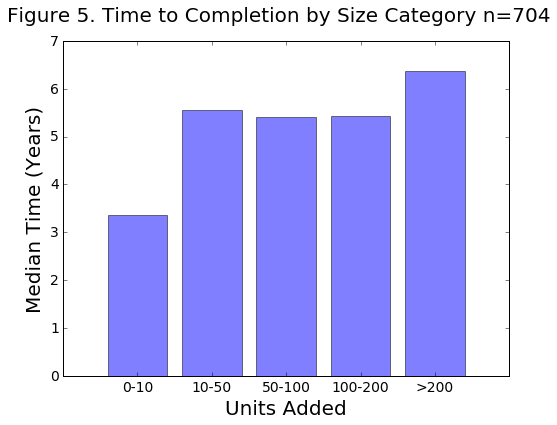

In [353]:
cat_medians=[]
categories=['0-10', '10-50', '50-100', '100-200', '>200']
for cat in categories:
    median = df[df['unitcat']==cat]['project_time_years'].median()
    cat_medians.append(median)
objects = df['unitcat'].unique()
y_pos = np.arange(len(objects))

plt.figure(1, figsize=(8,6), )
plt.suptitle('Figure 5. Time to Completion by Size Category' + ' n='+str(df[pd.notnull(df['project_time_years'])].count()['project_time_years']), fontsize=20)
plt.ylabel('Median Time (Years)', fontsize=20)
plt.xlabel('Units Added', fontsize=20)
plt.bar(y_pos, cat_medians, align='center', alpha=0.5)
plt.xticks(y_pos, categories, fontsize=14)
plt.yticks(fontsize = 14)
plt.savefig(output+'bar_chart_times.png')
plt.show()

# Figures 3 and 6. Breakdown time by stage of process

In [355]:
df.shape

(2248, 34)

In [360]:
#in order to use as much data as possible, I am not keeping all data and just creating time vars where we can (i.e. where they are nonnull)
def permit_time(value):
    returnval=np.nan
    if pd.notnull(value['BP_date']) & pd.notnull(value['first_date']):
        returnval=((dateutil.parser.parse(value['BP_date']) - dateutil.parser.parse(value['first_date'])).days)/365
    return returnval
def bp_time(value):
    returnval=np.nan
    if pd.notnull(value['con_date']) & pd.notnull(value['BP_date']):
        returnval=((dateutil.parser.parse(value['con_date']) - dateutil.parser.parse(value['BP_date'])).days)/365
    return returnval
def con_time(value):
    returnval=np.nan
    if pd.notnull(value['comp_date']) & pd.notnull(value['con_date']):
        returnval=((dateutil.parser.parse(value['comp_date']) - dateutil.parser.parse(value['con_date'])).days)/365
    return returnval
    
df['permit_time']=df.apply(permit_time, axis=1)
df['bp_time']=df.apply(bp_time, axis=1)
df['con_time']=df.apply(con_time, axis=1)

In [361]:
df['permit_time'].describe()

count    1077.000000
mean        2.176594
std         2.106910
min         0.002740
25%         0.819178
50%         1.490411
75%         2.638356
max        13.934247
Name: permit_time, dtype: float64

In [362]:
df['bp_time'].describe()

count    612.000000
mean       1.098097
std        1.195485
min        0.054795
25%        0.407534
50%        0.683562
75%        1.283562
max        7.153425
Name: bp_time, dtype: float64

In [363]:
df['con_time'].describe()

count    704.000000
mean       1.249856
std        1.401476
min        0.000000
25%        0.439041
50%        0.824658
75%        1.476712
max        8.810959
Name: con_time, dtype: float64

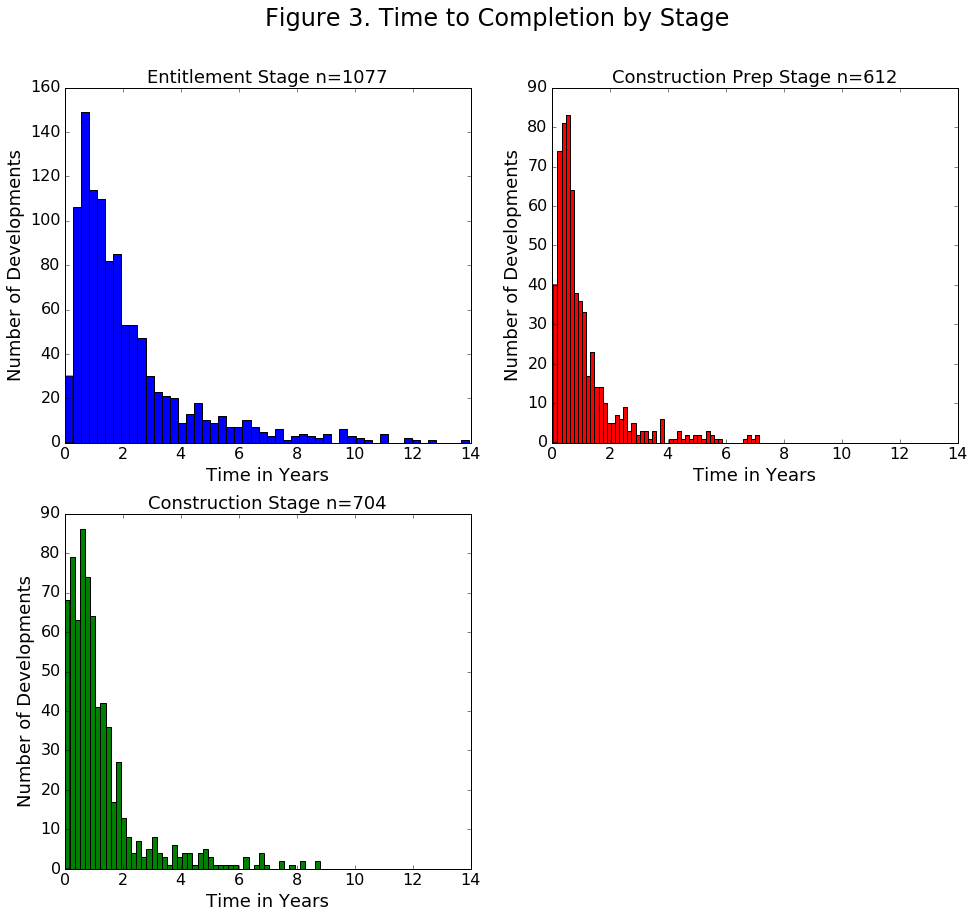

In [374]:
plt.figure(1, figsize=(16,14), )
plt.suptitle("Figure 3. Time to Completion by Stage", fontsize=24)

ax = plt.subplot(221)
ax.set_title("Entitlement Stage"+ ' n='+str(df[pd.notnull(df['permit_time'])].count()['permit_time']), fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
#plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df[pd.notnull(df['permit_time'])]['permit_time'], bins=50, color='b')

ax = plt.subplot(222)
ax.set_title("Construction Prep Stage" + ' n='+str(df[pd.notnull(df['bp_time'])].count()['bp_time']), fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
#plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df[pd.notnull(df['bp_time'])]['bp_time'], bins=50, color='r')

ax = plt.subplot(223)
ax.set_title("Construction Stage"+ ' n='+str(df[pd.notnull(df['con_time'])].count()['con_time']), fontsize=18)
ax.set_xlabel('Time in Years', fontsize=18)
ax.set_ylabel('Number of Developments', fontsize=18)
plt.xlim([0,14])
#plt.ylim([0,80])
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
ax.hist(df[pd.notnull(df['con_time'])]['con_time'], bins=50, color='g')

plt.savefig(output+'big_hist.png')

In [376]:
ent_medians=[]
bp_medians=[]
cons_medians=[]
ent_number=0
bp_number=0
cons_number=0
categories=['0-10', '10-50', '50-100', '100-200', '>200']
for cat in categories:
    median1 = df[df['unitcat']==cat]['permit_time'].median()
    median2 = df[df['unitcat']==cat]['bp_time'].median()
    median3 = df[df['unitcat']==cat]['con_time'].median()
    ent_number=ent_number+df[df['unitcat']==cat]['permit_time'].count() #count sample size for non-missing y variable
    bp_number=bp_number+df[df['unitcat']==cat]['bp_time'].count()
    cons_number=cons_number+df[df['unitcat']==cat]['con_time'].count()
    
    ent_medians.append(median1)
    bp_medians.append(median2)
    cons_medians.append(median3)
objects = df['unitcat'].unique()
y_pos = np.arange(len(objects))

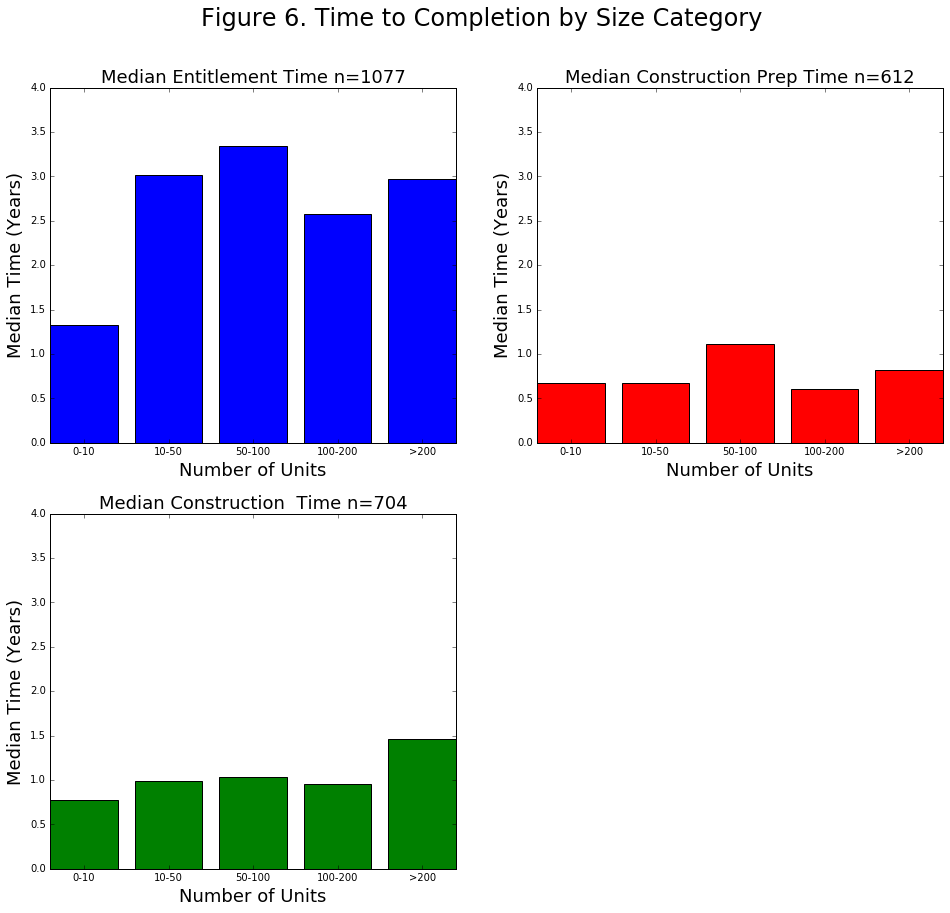

In [377]:
plt.figure(1, figsize=(16,14), )
plt.suptitle("Figure 6. Time to Completion by Size Category", fontsize=24)

ax = plt.subplot(221)
ax.set_title('Median Entitlement Time'+' n='+str(ent_number), fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Median Time (Years)', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, ent_medians, align='center', color='b')

ax = plt.subplot(222)
ax.set_title('Median Construction Prep Time'+' n='+str(bp_number), fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Median Time (Years)', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, bp_medians, align='center', color='r')

ax = plt.subplot(223)
ax.set_title('Median Construction  Time'+' n='+str(cons_number), fontsize=18)
ax.set_xlabel('Number of Units', fontsize=18)
ax.set_ylabel('Median Time (Years)', fontsize=18)
ax.set_xticks(y_pos)
ax.set_xticklabels(categories)
ax.set_ylim([0,4])
ax.bar(y_pos, cons_medians, align='center', color='g')

plt.savefig(output+'big_bar.png')

# Figures 7 and 8. Create Neighborhood Graphs

In [380]:
# for these graphs, drop if neighborhood has sample with non-missing BP date less than 10. Brings sample for completed projects down to 692
for nhood in df['nhood'].value_counts().index:
    if df[df['nhood']==nhood]['BP_date'].count() <10:
        df=df[df['nhood']!=nhood]

In [382]:
df['ptime_unityears']=df['permit_time']/df['units']

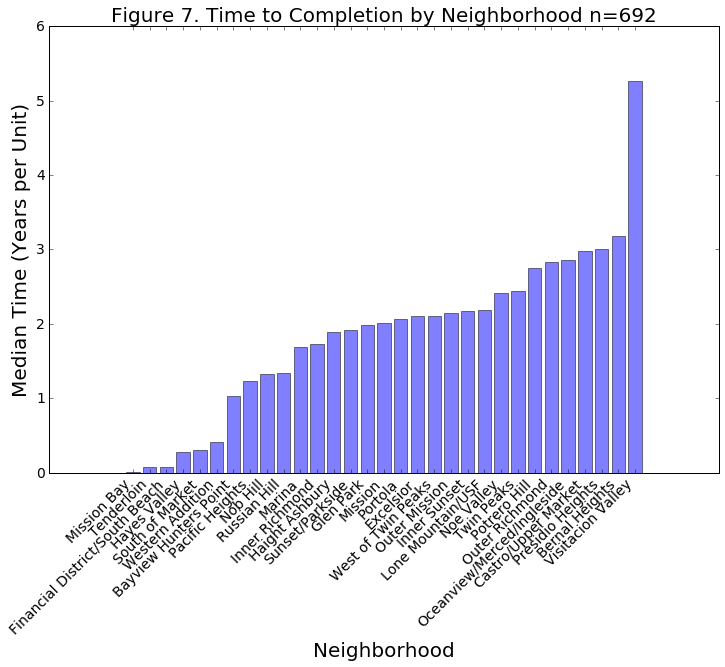

In [383]:
graph_options=['b', (12, 8)]
bar_graph('nhood','years_per_unit', 'Figure 7. Time to Completion by Neighborhood', 'Neighborhood', 'Median Time (Years per Unit)', df, True, graph_options)

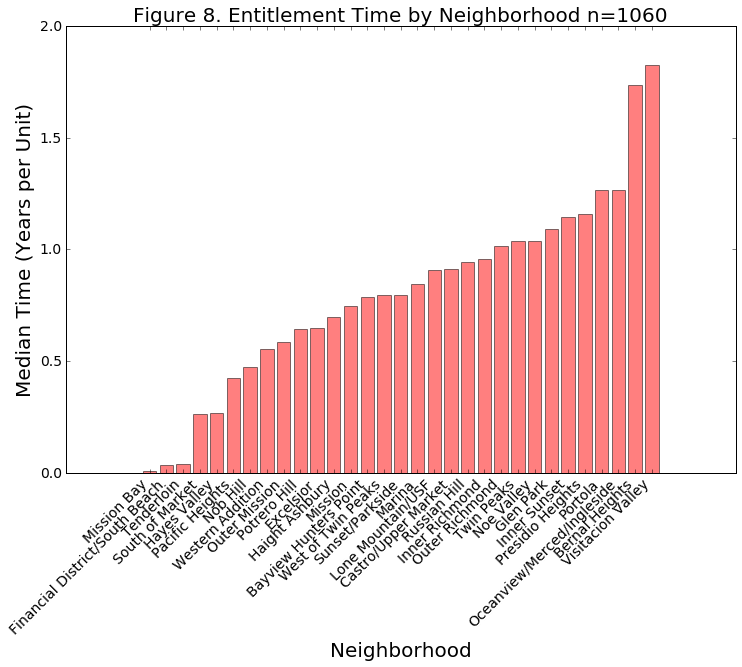

In [387]:
graph_options=['r', (12, 8)]
bar_graph('nhood','ptime_unityears', 'Figure 8. Entitlement Time by Neighborhood', 'Neighborhood', 'Median Time (Years per Unit)', df, True, graph_options)

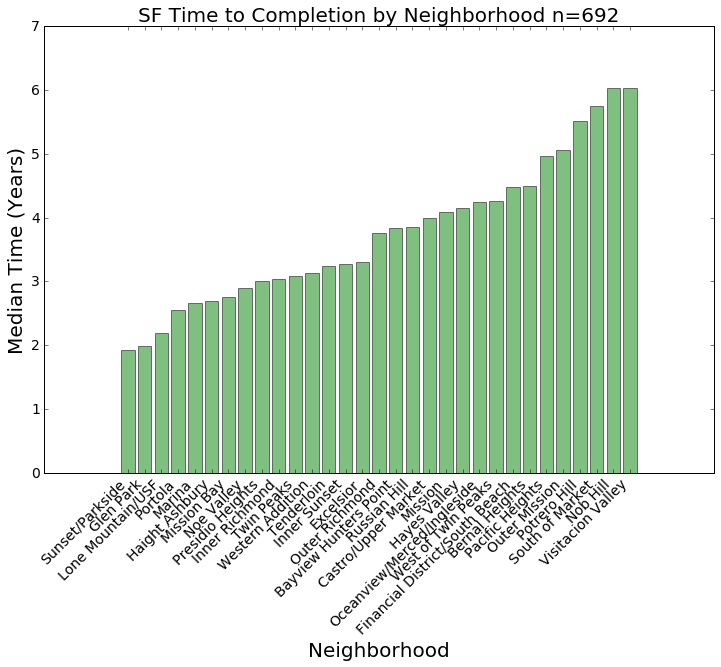

In [391]:
graph_options=['g', (12, 8)]
bar_graph('nhood','project_time_years', 'SF Time to Completion by Neighborhood', 'Neighborhood', 'Median Time (Years)', df, True, graph_options)

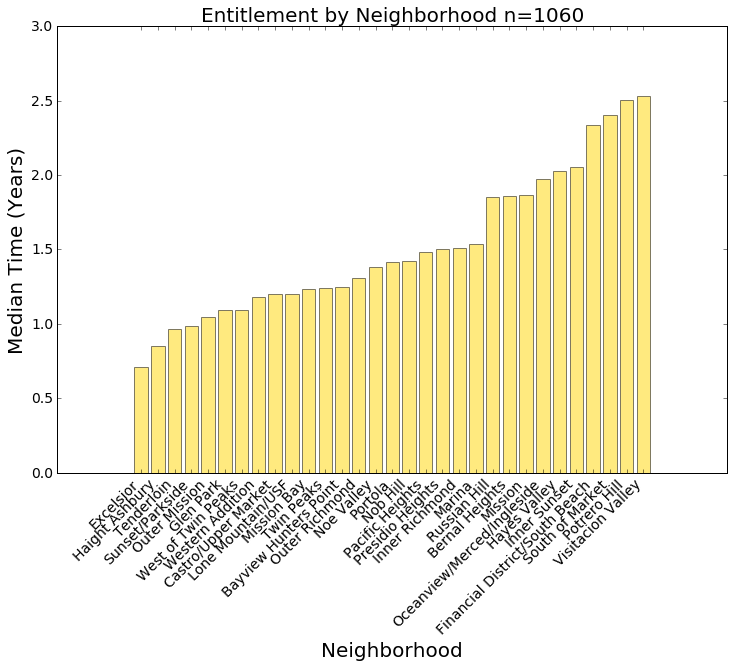

In [392]:
graph_options=['gold', (12, 8)]
bar_graph('nhood','permit_time', 'Entitlement by Neighborhood', 'Neighborhood', 'Median Time (Years)', df, True, graph_options)